# News Headline Classification

### Importing Required libraries

In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Flatten, LSTM, Dense, Input, Activation, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

### Importing the dataset

In [2]:
df = pd.read_json('News_Category_Dataset_v2.json', lines = True)

In [3]:
df.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [4]:
df.shape

(200853, 6)

### Checking the dataset for null values

In [5]:
df.isnull().sum()

category             0
headline             0
authors              0
link                 0
short_description    0
date                 0
dtype: int64

### Visualising the data

<AxesSubplot: xlabel='count', ylabel='category'>

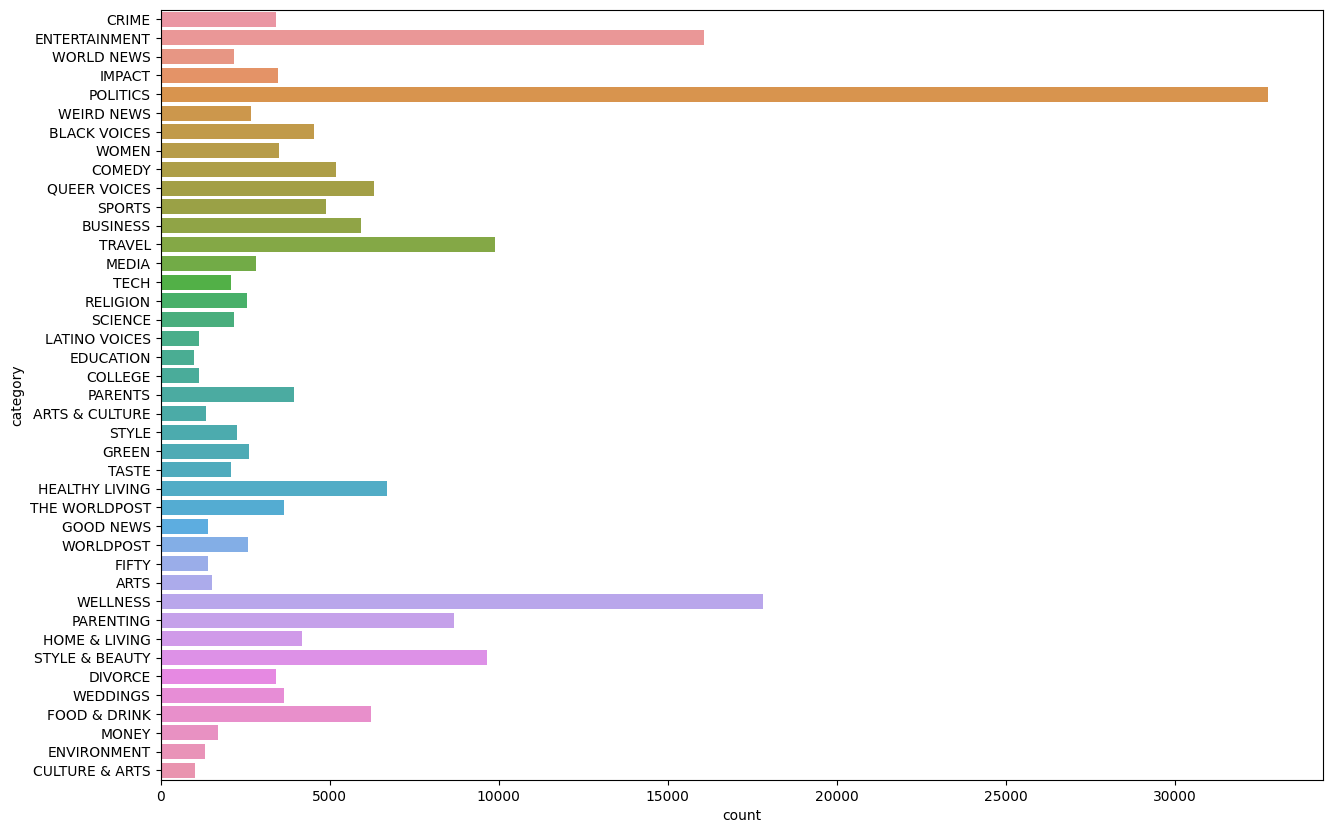

In [10]:
fig, ax = plt.subplots(figsize = (15, 10))
sns.countplot(ax = ax, y=df['category'])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200853 entries, 0 to 200852
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   category           200853 non-null  object        
 1   headline           200853 non-null  object        
 2   authors            200853 non-null  object        
 3   link               200853 non-null  object        
 4   short_description  200853 non-null  object        
 5   date               200853 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.2+ MB


### Converting the category column into category_label_encoding

In [8]:
category_label_enc = {value: key for key, value in enumerate(df.category.unique())}
category_label_enc

{'CRIME': 0,
 'ENTERTAINMENT': 1,
 'WORLD NEWS': 2,
 'IMPACT': 3,
 'POLITICS': 4,
 'WEIRD NEWS': 5,
 'BLACK VOICES': 6,
 'WOMEN': 7,
 'COMEDY': 8,
 'QUEER VOICES': 9,
 'SPORTS': 10,
 'BUSINESS': 11,
 'TRAVEL': 12,
 'MEDIA': 13,
 'TECH': 14,
 'RELIGION': 15,
 'SCIENCE': 16,
 'LATINO VOICES': 17,
 'EDUCATION': 18,
 'COLLEGE': 19,
 'PARENTS': 20,
 'ARTS & CULTURE': 21,
 'STYLE': 22,
 'GREEN': 23,
 'TASTE': 24,
 'HEALTHY LIVING': 25,
 'THE WORLDPOST': 26,
 'GOOD NEWS': 27,
 'WORLDPOST': 28,
 'FIFTY': 29,
 'ARTS': 30,
 'WELLNESS': 31,
 'PARENTING': 32,
 'HOME & LIVING': 33,
 'STYLE & BEAUTY': 34,
 'DIVORCE': 35,
 'WEDDINGS': 36,
 'FOOD & DRINK': 37,
 'MONEY': 38,
 'ENVIRONMENT': 39,
 'CULTURE & ARTS': 40}

### Preprocessing the dataset

In [161]:
def get_seq(t, token, train=True, max_seq_length=0):
    seq = token.texts_to_sequences(t)
    if train == True:
        max_seq_length = np.max(list(map(lambda x: len(x), seq)))
    seq = pad_sequences(seq, maxlen=max_seq_length, padding='post')
    return seq

def pi(df, lbl_map=None):
    df_copy = df.copy()
    df_copy = df_copy.loc[:, ['headline', 'category']]
    cat_sam = []

    for category in df['category'].unique():
        cat_slice = df.query("category == @category")
        cat_sam.append(cat_slice.sample(10000, random_state=1, replace = True))
        
    df_copy = pd.concat(cat_sam, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
    
    df_copy['category'] = df_copy['category'].replace(lbl_map)
    
    y = df_copy['category']
    X = df_copy['headline']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, shuffle=True, random_state=42)
    
    token = Tokenizer(num_words=10000)
    token.fit_on_texts(X_train)
    
    X_train = get_seq(X_train, token, train=True)
    X_test = get_seq(X_test, token, train=False, max_seq_length=X_train.shape[1])
    
    return X_train, X_test, y_train, y_test

In [162]:
x_train, x_test, y_train, y_test = pi(df, lbl_map=category_label_enc)

In [163]:
x_train

array([[  15,    8,   14, ...,    0,    0,    0],
       [ 561,  717,  820, ...,    0,    0,    0],
       [5972, 5676,  837, ...,    0,    0,    0],
       ...,
       [ 129,    6,  974, ...,    0,    0,    0],
       [2907,   85,   11, ...,    0,    0,    0],
       [ 299, 4949, 7314, ...,    0,    0,    0]])

In [164]:
x_test

array([[2500,   75, 1560, ...,    0,    0,    0],
       [ 342,  227,    2, ...,    0,    0,    0],
       [  17,  332, 6159, ...,    0,    0,    0],
       ...,
       [1128,    7,  101, ...,    0,    0,    0],
       [ 270,   85, 1386, ...,    0,    0,    0],
       [3778, 9396, 3060, ...,    0,    0,    0]])

In [165]:
y_train

42845     36
59474      8
222862    34
54167     11
170584    26
          ..
259178     2
365838    39
131932    39
146867    37
121958    23
Name: category, Length: 307500, dtype: int64

In [166]:
y_test

258473    34
403774    21
366961    14
9745       3
22246     37
          ..
83375     21
349093    24
89917      8
392158    25
275855     6
Name: category, Length: 102500, dtype: int64

In [167]:
print('x_train shape = ', x_train.shape)
print('x_test shape = ', x_test.shape)

x_train shape =  (307500, 36)
x_test shape =  (102500, 36)


In [168]:
num_classes = len(df['category'].unique())
print(num_classes)

41


In [169]:
input_shape = (x_train.shape[1],)
print(input_shape)

(36,)


### Creating the model

In [170]:
vocab_size = 10000
embedding_dim = 64
max_length = x_train.shape[0]

In [171]:
def modelfn(input_shape = input_shape):
    x_input = Input(shape = input_shape)
    x = x_input
    x = Embedding(input_dim = vocab_size, output_dim = embedding_dim, input_length = max_length, trainable = True)(x)
    x = LSTM(64, return_sequences = True)(x)
    x = Flatten()(x)
    x = Dense(128)(x)
    x = Activation('relu')(x)
    x = Dense(128)(x)
    x = Activation('relu')(x)
    x = Dense(num_classes)(x)
    x = Activation('softmax')(x)
    model = Model(inputs = x_input, outputs = x, name = 'modelfn')
    return model

In [178]:
lossfn = SparseCategoricalCrossentropy()
optimizerfn = Adam(0.0001)
callbackfn=[tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]

In [179]:
model = modelfn(input_shape = input_shape)

In [180]:
model.compile(optimizer = optimizerfn, loss = lossfn, metrics = ["accuracy"])

### Model summary

In [181]:
model.summary()

Model: "modelfn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, 36)]              0         
                                                                 
 embedding_26 (Embedding)    (None, 36, 64)            640000    
                                                                 
 lstm_31 (LSTM)              (None, 36, 64)            33024     
                                                                 
 flatten_21 (Flatten)        (None, 2304)              0         
                                                                 
 dense_33 (Dense)            (None, 128)               295040    
                                                                 
 activation_33 (Activation)  (None, 128)               0         
                                                                 
 dense_34 (Dense)            (None, 128)               1651

### Training the model

In [182]:
history = model.fit(x_train, y_train, validation_split=0.2, batch_size=64, epochs=100, callbacks = callbackfn)

Epoch 1/100
3844/3844 [==============================] - 163s 42ms/step - loss: 2.9116 - accuracy: 0.2046 - val_loss: 2.4229 - val_accuracy: 0.3258
Epoch 2/100
3844/3844 [==============================] - 160s 42ms/step - loss: 2.2447 - accuracy: 0.3800 - val_loss: 2.1557 - val_accuracy: 0.4085
Epoch 3/100
3844/3844 [==============================] - 160s 42ms/step - loss: 2.0280 - accuracy: 0.4428 - val_loss: 2.0163 - val_accuracy: 0.4491
Epoch 4/100
3844/3844 [==============================] - 160s 42ms/step - loss: 1.8849 - accuracy: 0.4863 - val_loss: 1.9081 - val_accuracy: 0.4831
Epoch 5/100
3844/3844 [==============================] - 161s 42ms/step - loss: 1.7806 - accuracy: 0.5159 - val_loss: 1.8403 - val_accuracy: 0.5033
Epoch 6/100
3844/3844 [==============================] - 160s 42ms/step - loss: 1.7061 - accuracy: 0.5381 - val_loss: 1.7883 - val_accuracy: 0.5207
Epoch 7/100
3844/3844 [==============================] - 160s 42ms/step - loss: 1.6402 - accuracy: 0.5554 - val_

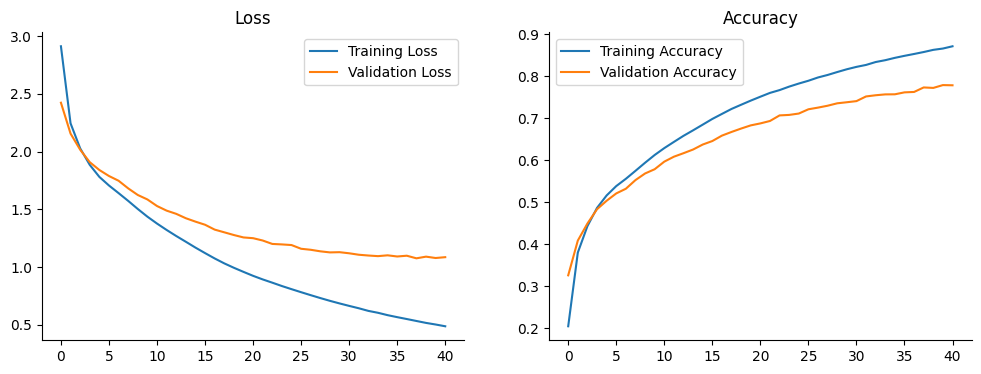

In [183]:
fig, axes = plt.subplots(1, 2, figsize = (12, 4))

sns.lineplot(x = range(len(history.history["loss"])), y = history.history["loss"], ax = axes[0], label = "Training Loss")
sns.lineplot(x = range(len(history.history["loss"])), y = history.history["val_loss"], ax = axes[0], label = "Validation Loss")

sns.lineplot(x = range(len(history.history["accuracy"])), y = history.history["accuracy"], ax = axes[1], label = "Training Accuracy")
sns.lineplot(x = range(len(history.history["accuracy"])), y = history.history["val_accuracy"], ax = axes[1], label = "Validation Accuracy")
axes[0].set_title("Loss"); axes[1].set_title("Accuracy")

sns.despine()
plt.show()

### Testing the model

In [184]:
model.evaluate(x_test, y_test)[1]

3204/3204 [==============================] - 25s 8ms/step - loss: 1.0924 - accuracy: 0.7704


0.770429253578186